# AI Music Generation
I build a Deep Learning NLP model using LSTMs to generate piano music

In [1]:
import os

songs_path = r"C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs"
if os.path.exists(songs_path):
    print(f"Folder exists: {songs_path}")
else:
    print(f"Folder not found: {songs_path}")

Folder exists: C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs


#### Import necesary packages

In [2]:
from music21 import converter, instrument, note, chord
import glob
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical

In [3]:
from music21 import converter, instrument, note, chord
import glob
import os

# Tentukan path folder
songs_path = r"C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs"

# Ambil semua file MIDI di folder tersebut
midi_files = glob.glob(songs_path + "/*.mid")

# List untuk menyimpan not dan akord
notes = []

for file in midi_files:
    if os.path.exists(file) and os.path.getsize(file) > 0:  # Pastikan file ada dan tidak kosong
        try:
            midi = converter.parse(file)
            print(f"Parsing {file}...")

            # Memisahkan partisi instrumen (jika ada)
            parts = instrument.partitionByInstrument(midi)
            if parts:  # Jika ada partisi instrumen
                notes_to_parse = parts.parts[0].recurse()
            else:  # Jika tidak ada partisi instrumen
                notes_to_parse = midi.flat.notes

            # Iterasi melalui not dan akord
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))  # Tambahkan not
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))  # Tambahkan akord

        except Exception as e:
            print(f"Error saat memproses {file}: {e}")
    else:
        print(f"File {file} kosong atau tidak ditemukan.")

# Ambil subset data (misalnya, 90% pertama dari notes)
subset_size = int(len(notes) * 0.8)
notes = notes[:subset_size]

print(f"Total number of notes: {len(notes)}")

# Get total number of classes for the model (i.e. number of unique notes in our dataset)
vocab_len = len(set(notes))

print("Total number of classes = " + str(vocab_len))


Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\A Day in the Life (feat Michael Rose and Menny More).mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\Ach_ ihr Männer.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\Adante Grazioso - Sonate en la Majeur_ K 300.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\alb_esp1.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\alb_esp2.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\alb_esp3.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\alb_esp4.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\alb_esp5.mid...
Parsing C:\Users\sheninagt\Documents\generativai\AI_Music_Generator-master\songs\alb_esp6.mid...
Parsing C:\Users\sheninagt\Documents\gen

#### Load the pre-processed notes saved earlier

In [4]:
print(notes)

['0.4.7', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '7.11.2', '7.11.2', '11.2.6', '11.2.6', '11.2.4', '11.2.4', '11.2', '11.2', '7.0', '11.0.4', 'A2', 'A2', 'A2', 'A2', '9.11.0', 'A3', 'A2', '9', 'G3', '11.2', '11.2', 'F#3', '11.2', '11.2', '4.7.11', '4.7.11', '7.11.2', '7.11.2', '0.4.7', '5.9.0', '5.9.0', '4.7.11', '11.2.4.7', '11.2.4.7', '0.4.7', '5.9.0', '4.7.11', '0.4.7', 'C3', '0.4.7', 'D3', 'G2', '11.2', '11.2', 'F#2', '11.2', '11.2', 'E3', '11.2', '11.2', '11.2', 'D3', '11.2', '11.2', '0.4.7', '4.7.11', 'A2', '4.9', '4.9', '11.0', 'A3', '11.0', 'A3', '7.11.2', '7.11.2', '11.2.6', '11.2.6', 'E3', 'E3', 'D3', '11.2', '0.4.7', '5.9.0', 'E3', '4.7.11', '4.7.11', 'D3', '4.7.11', '4.7.11', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '0', '0.4.7', '4.7', 'G3', '11.2', '11.2', 'F#3', '11.2', '11.2', 'E3', '11.2', '11.2', 'D3', '11.2', '11.2', '0.4.7', '11.0.4.7', 'A2', 'A2', '11.0', 'A3', 'A2', 'G3', '11.2', '11.2', 'F#3', '11.2', '11.2', 'E3', '11.2', '11

#### Prepare Sequential data for LSTM

In [5]:
# Pastikan notes tidak kosong
if not notes:
    raise ValueError("Notes list kosong. Pastikan file MIDI valid dan terproses dengan benar.")

# Tentukan sequence_length sebelum digunakan
sequence_length = 100
if len(notes) <= sequence_length:
    raise ValueError(f"Jumlah notes ({len(notes)}) kurang dari atau sama dengan sequence_length ({sequence_length}).")

# Buat mapping dari note ke integer
pitch_names = sorted(set(notes))
note_to_int = dict((elem, num) for num, elem in enumerate(pitch_names))
print(note_to_int)

{'0': 0, '0.1': 1, '0.1.2': 2, '0.1.3': 3, '0.1.3.4': 4, '0.1.3.5': 5, '0.1.3.5.6': 6, '0.1.3.5.6.8': 7, '0.1.3.5.6.8.10': 8, '0.1.3.5.7': 9, '0.1.3.5.8': 10, '0.1.3.5.8.9': 11, '0.1.5': 12, '0.1.5.8': 13, '0.1.6': 14, '0.2': 15, '0.2.3': 16, '0.2.3.5': 17, '0.2.3.6': 18, '0.2.3.7': 19, '0.2.4': 20, '0.2.4.5': 21, '0.2.4.6': 22, '0.2.4.6.9': 23, '0.2.4.7': 24, '0.2.5': 25, '0.2.5.7': 26, '0.2.6': 27, '0.2.6.7': 28, '0.2.7': 29, '0.3': 30, '0.3.5': 31, '0.3.5.7': 32, '0.3.5.7.8': 33, '0.3.5.8': 34, '0.3.6': 35, '0.3.6.8': 36, '0.3.6.9': 37, '0.3.7': 38, '0.4': 39, '0.4.5': 40, '0.4.6': 41, '0.4.7': 42, '0.4.8': 43, '0.5': 44, '0.5.6': 45, '0.6': 46, '1': 47, '1.2': 48, '1.2.3': 49, '1.2.4': 50, '1.2.4.6': 51, '1.2.4.6.7.9': 52, '1.2.4.6.7.9.11': 53, '1.2.4.6.9': 54, '1.2.4.8': 55, '1.2.5.6': 56, '1.2.6': 57, '1.2.6.7': 58, '1.2.6.8': 59, '1.2.6.9': 60, '1.2.7': 61, '1.3': 62, '1.3.4': 63, '1.3.4.5.6.8.10': 64, '1.3.4.6': 65, '1.3.4.6.8': 66, '1.3.4.6.8.10': 67, '1.3.4.8': 68, '1.3.5': 6

Membuat input dan output untuk pelatihan model

In [6]:
network_input = []
network_output = []

for i in range(len(notes) - sequence_length):
    seq_inp = notes[i:i + sequence_length]
    seq_out = notes[i + sequence_length]

    network_input.append([note_to_int[ch] for ch in seq_inp])
    network_output.append(note_to_int[seq_out])

In [7]:
print(network_input[0])

[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 469, 469, 194, 194, 188, 188, 184, 184, 451, 162, 599, 599, 599, 599, 578, 600, 599, 547, 674, 184, 184, 655, 184, 184, 344, 344, 469, 469, 42, 401, 401, 344, 190, 190, 42, 401, 344, 42, 626, 42, 633, 673, 184, 184, 654, 184, 184, 647, 184, 184, 184, 633, 184, 184, 42, 344, 599, 356, 356, 150, 600, 150, 600, 469, 469, 194, 194, 647, 647, 633, 184, 42, 401, 647, 344, 344, 633, 344, 344, 42, 42, 42, 42, 0, 42, 341, 674, 184, 184, 655]


In [8]:
def data_generator(notes, note_to_int, sequence_length, vocab_len, batch_size):
    while True:  # Loop tanpa henti untuk menghasilkan batch
        batch_inp = []
        batch_out = []
        for i in range(batch_size):
            # Pilih urutan acak
            start = np.random.randint(0, len(notes) - sequence_length)
            seq_inp = notes[start:start + sequence_length]
            seq_out = notes[start + 1:start + sequence_length + 1]

            # Pastikan panjang urutan sesuai dengan sequence_length
            if len(seq_inp) == sequence_length and len(seq_out) == sequence_length:
                batch_inp.append([note_to_int[ch] for ch in seq_inp])
                batch_out.append(note_to_int[seq_out[-1]])  # Prediksi note berikutnya

        # Encode input sequence sebagai one-hot vectors
        inp_encoded = np.array(
            [to_categorical(seq, num_classes=vocab_len) for seq in batch_inp],
            dtype='float32'
        )

        # Encode output sequence sebagai one-hot vectors
        out_encoded = to_categorical(batch_out, num_classes=vocab_len)

        # Pastikan bahwa batch tidak kosong
        if len(batch_inp) == batch_size:
            yield inp_encoded, out_encoded

In [9]:
# Store number of training examples
n_patterns = len(network_input)
print(n_patterns)

131894


MENGUBAH INPUT KE BENTUK YANG SESUAI UNTUK LSTM

In [10]:
import numpy as np

# Pastikan network_input telah terisi
if network_input is None or len(network_input) == 0:
    raise ValueError("Network input kosong. Pastikan data MIDI terproses dengan benar.")

# Mengonversi network_input menjadi numpy array
network_input = np.array(network_input)

# Memeriksa shape setelah konversi
print(network_input.shape)  # Sekarang seharusnya bisa mengakses shape

(131894, 100)


Konversi output ke one-hot encoding

In [11]:
import numpy as np

# Pastikan network_input dan network_output sudah terisi
if network_input is None or len(network_input) == 0:
    raise ValueError("Network input kosong. Pastikan data MIDI terproses dengan benar.")
if network_output is None or len(network_output) == 0:
    raise ValueError("Network output kosong. Pastikan data keluaran diproses dengan benar.")

# Mengonversi network_input dan network_output menjadi numpy array
network_input = np.array(network_input)
network_output = np.array(network_output)

# Memeriksa shape setelah konversi
print(network_input.shape, network_output.shape)  # Sekarang bisa mengakses shape

(131894, 100) (131894,)


### Create LSTM model architecture

In [12]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    network_input, network_output, test_size=0.2, random_state=42
)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if not tf.config.list_physical_devices('GPU'):
    print("Peringatan: GPU tidak terdeteksi. Proses mungkin lambat.")

def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Model definition
model = Sequential([
    LSTM(256, input_shape=(sequence_length, vocab_len), return_sequences=True),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(256),
    Dense(128, activation='relu'),
    Dense(vocab_len, activation='softmax')  # Sesuaikan vocab_len dengan jumlah kelas unik (430)
])

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', root_mean_squared_error])

# Model summary
model.summary()

Num GPUs Available:  0
Peringatan: GPU tidak terdeteksi. Proses mungkin lambat.


c:\Users\sheninagt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 256)       │       957,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 678)            │        87,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,128,422 (8.12 MB)

 Trainable params: 2,128,422 (8.12 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
filtered_notes = [note for note in notes if note in note_to_int]
print(f"Jumlah data valid: {len(filtered_notes)} dari {len(notes)} total notes.")

Jumlah data valid: 131994 dari 131994 total notes.


In [15]:
# Validasi data notes
notes = filtered_notes

# Parameter yang diperlukan
sequence_length = 100  # Panjang sequence
batch_size = 256        # Ukuran batch

# Split data untuk pelatihan dan validasi
notes_valid = notes[int(0.8 * len(notes)):]  # 20% terakhir untuk validasi
notes_train = notes[:int(0.8 * len(notes))]  # 80% untuk pelatihan

# Validasi panjang data
if len(notes_train) <= sequence_length:
    raise ValueError(f"Data pelatihan terlalu kecil ({len(notes_train)}). Harus lebih besar dari sequence_length ({sequence_length}).")
if len(notes_valid) <= sequence_length:
    raise ValueError(f"Data validasi terlalu kecil ({len(notes_valid)}). Harus lebih besar dari sequence_length ({sequence_length}).")

# Generator untuk data pelatihan dan validasi
train_gen = data_generator(notes_train, note_to_int, sequence_length, vocab_len, batch_size)
val_gen = data_generator(notes_valid, note_to_int, sequence_length, vocab_len, batch_size)

# Tentukan steps per epoch dan validation steps
steps_per_epoch = (len(notes_train) - sequence_length) // batch_size
validation_steps = (len(notes_valid) - sequence_length) // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 412
Validation steps: 102


#### Menambahkan Callbacks

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callback_list = [
    ModelCheckpoint(filepath="best_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
]

Epoch 1/25
515/515 ━━━━━━━━━━━━━━━━━━━━ 425s 821ms/step - accuracy: 0.0182 - loss: 5.1593 - root_mean_squared_error: 0.0382 - val_accuracy: 0.0107 - val_loss: 5.2778 - val_root_mean_squared_error: 0.0383 - learning_rate: 0.0010
Epoch 2/25
515/515 ━━━━━━━━━━━━━━━━━━━━ 442s 859ms/step - accuracy: 0.0213 - loss: 4.9834 - root_mean_squared_error: 0.0382 - val_accuracy: 0.0244 - val_loss: 5.0305 - val_root_mean_squared_error: 0.0382 - learning_rate: 0.0010
Epoch 3/25
515/515 ━━━━━━━━━━━━━━━━━━━━ 438s 850ms/step - accuracy: 0.0329 - loss: 4.8024 - root_mean_squared_error: 0.0381 - val_accuracy: 0.0226 - val_loss: 5.0050 - val_root_mean_squared_error: 0.0382 - learning_rate: 0.0010
Epoch 4/25
515/515 ━━━━━━━━━━━━━━━━━━━━ 440s 855ms/step - accuracy: 0.0418 - loss: 4.6504 - root_mean_squared_error: 0.0381 - val_accuracy: 0.0386 - val_loss: 4.9243 - val_root_mean_squared_error: 0.0381 - learning_rate: 0.0010
Epoch 5/25
515/515 ━━━━━━━━━━━━━━━━━━━━ 442s 858ms/step - accuracy: 0.0622 - loss: 4.436

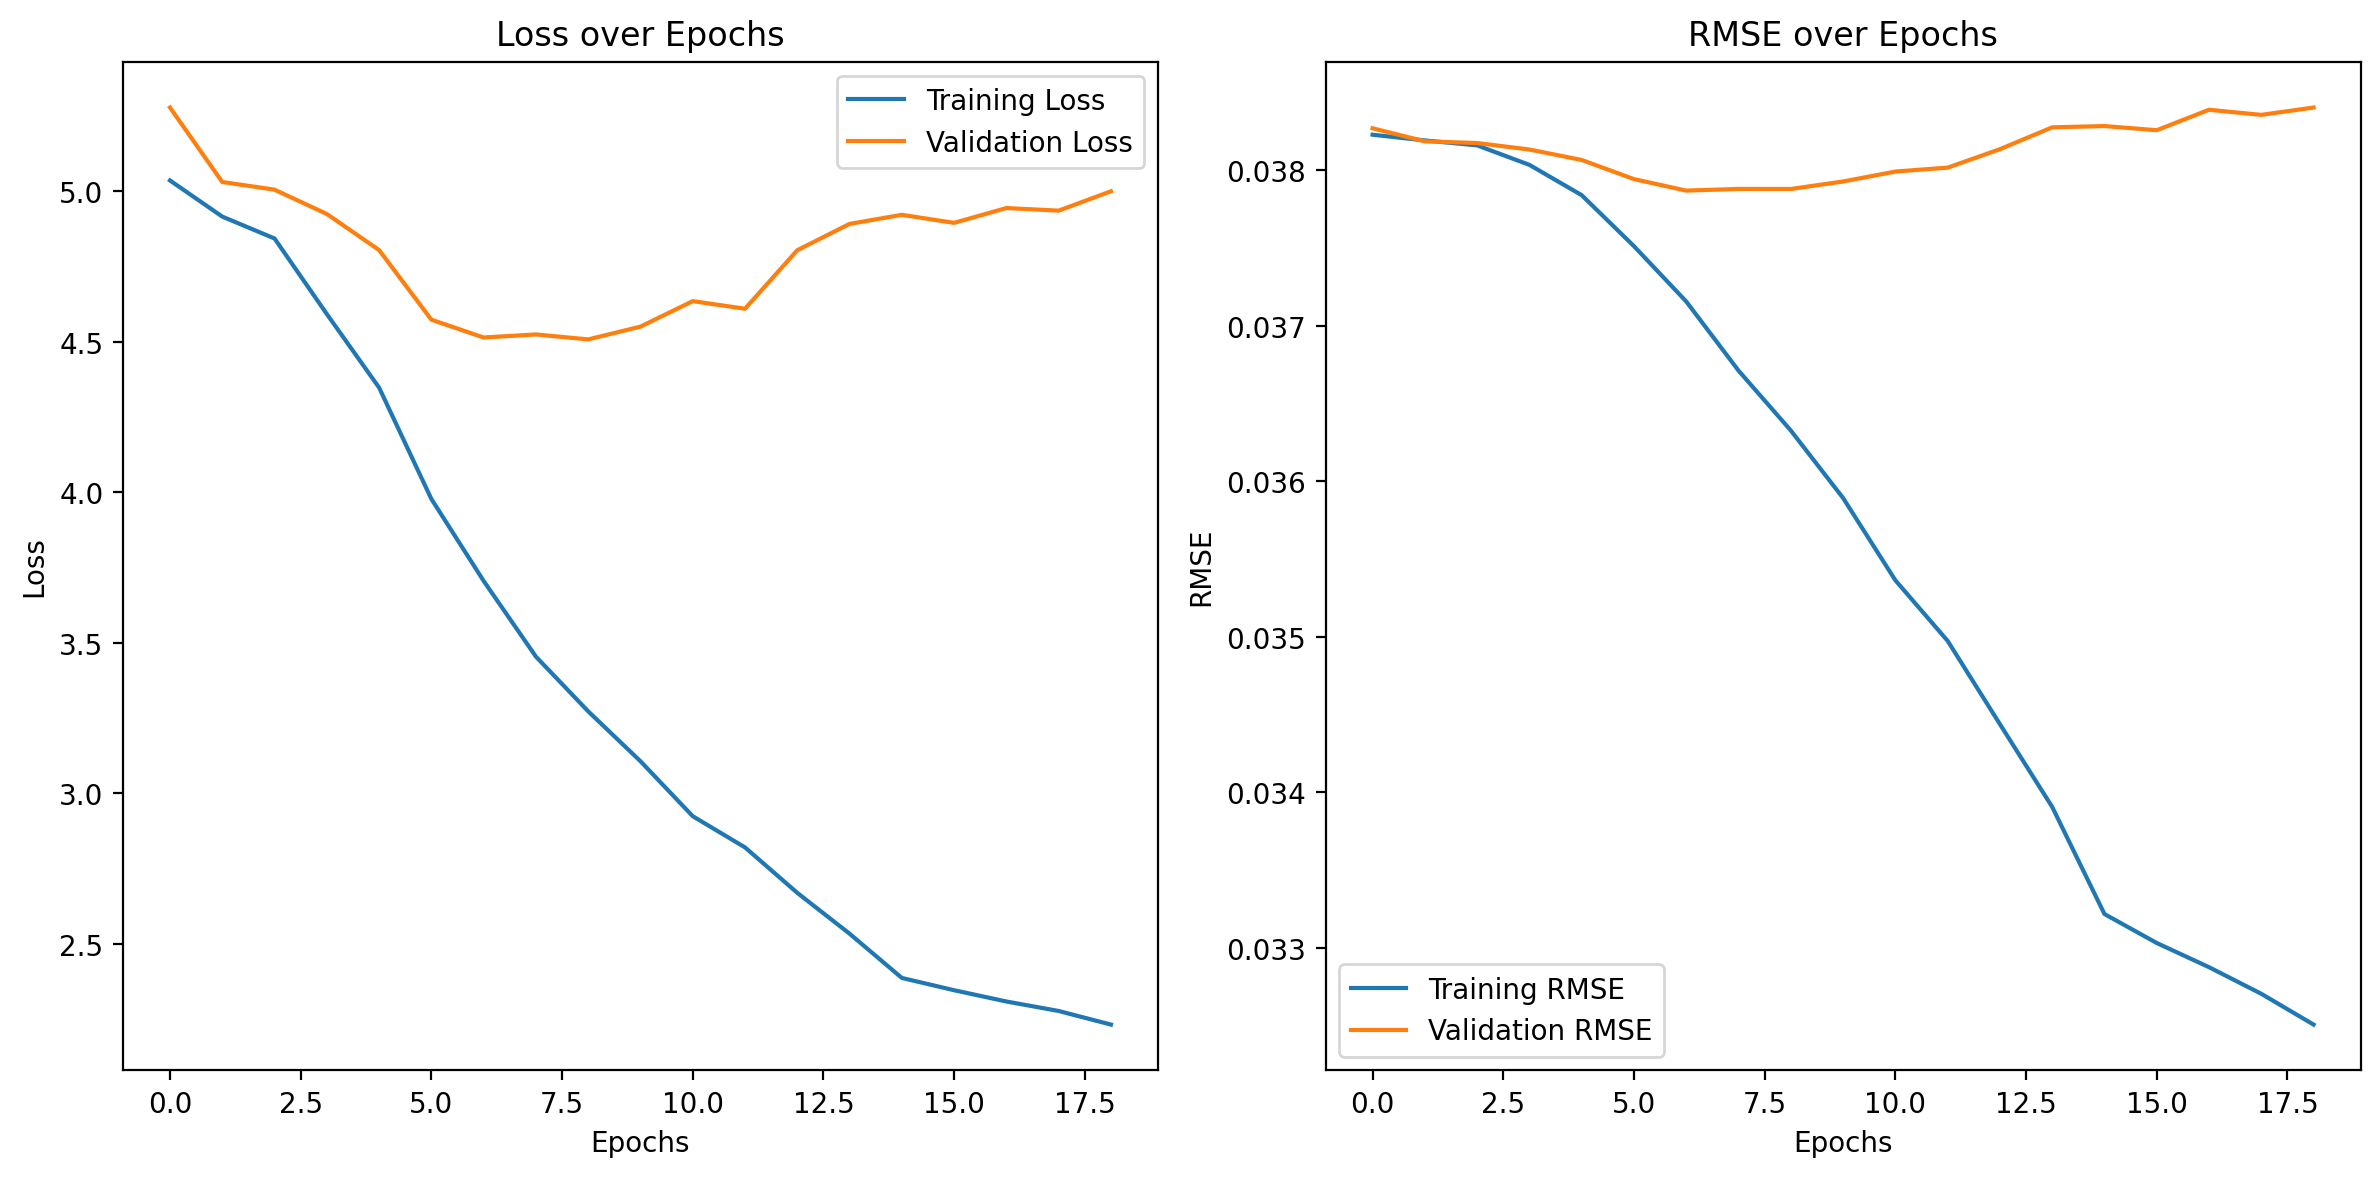

In [17]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir="./logs")

steps_per_epoch = len(notes) // batch_size  # Perkiraan jumlah batch per epoch

# Misalkan notes_valid adalah subset data validasi Anda
notes_valid = notes[int(0.8 * len(notes)):]  # 20% terakhir untuk validasi

val_gen = data_generator(notes_valid, note_to_int, sequence_length, vocab_len, batch_size)

if steps_per_epoch <= 0:
    raise ValueError(f"steps_per_epoch ({steps_per_epoch}) harus lebih besar dari 0.")
if validation_steps <= 0:
    raise ValueError(f"validation_steps ({validation_steps}) harus lebih besar dari 0.")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=25,
    callbacks=callback_list
)

# Save the trained model
model.save("model.keras")
print("Model has been saved as 'model.keras'.")

# Visualisasi loss dan RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
if 'root_mean_squared_error' in history.history:
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('RMSE over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
else:
    print("RMSE tidak tersedia dalam sejarah pelatihan.")

plt.tight_layout()
plt.show()

In [20]:
if 'model' not in globals():
    raise NameError("Model belum didefinisikan. Pastikan Anda telah menjalankan kotak 13.")

val_loss, val_acc, val_rmse = model.evaluate(
    val_gen,
    steps=validation_steps,
    verbose=1
)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")
print(f"Validation RMSE: {val_rmse}")


102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.0930 - loss: 4.4930 - root_mean_squared_error: 0.0378
Validation Loss: 4.514957427978516
Validation Accuracy: 0.08865655958652496
Validation RMSE: 0.0378594696521759


In [21]:
if 'notes' not in globals():
    raise NameError("Variabel 'notes' tidak didefinisikan. Pastikan Anda telah menjalankan kotak 3 dan kotak 14.")

export_data = {
    "notes": notes,
    "pitch_names": pitch_names,
    "vocab_len": vocab_len
}

with open("notes_data.pkl", "wb") as file:
    pickle.dump(export_data, file)

print("Data berhasil disimpan ke 'notes_data.pkl'")


Data berhasil disimpan ke 'notes_data.pkl'
